In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas_datareader import data
import scipy.optimize as sco

In [3]:
tickers = ['AGG', 'EBND', 'URTH', 'EEM']
data_source = 'yahoo'
start_date = '2007-09-30'
end_date = '2017-09-30'

In [4]:
panel_data = data.DataReader(tickers, data_source, start_date, end_date)
close_px = panel_data.loc['Adj Close'].dropna()

In [5]:
# Check the ordering of the data that has been returned and the history available
close_px.head()

,AGG,EBND,EEM,URTH
Date,,,,
2015-01-02,103.767639,28.114489,37.001228,67.834061
2015-01-05,103.993141,27.845690,36.342709,66.243530
2015-01-06,104.256264,27.746136,36.189999,65.363052
2015-01-07,104.237488,28.084621,36.972599,66.025772
2015-01-08,104.077736,28.194134,37.602489,67.493225


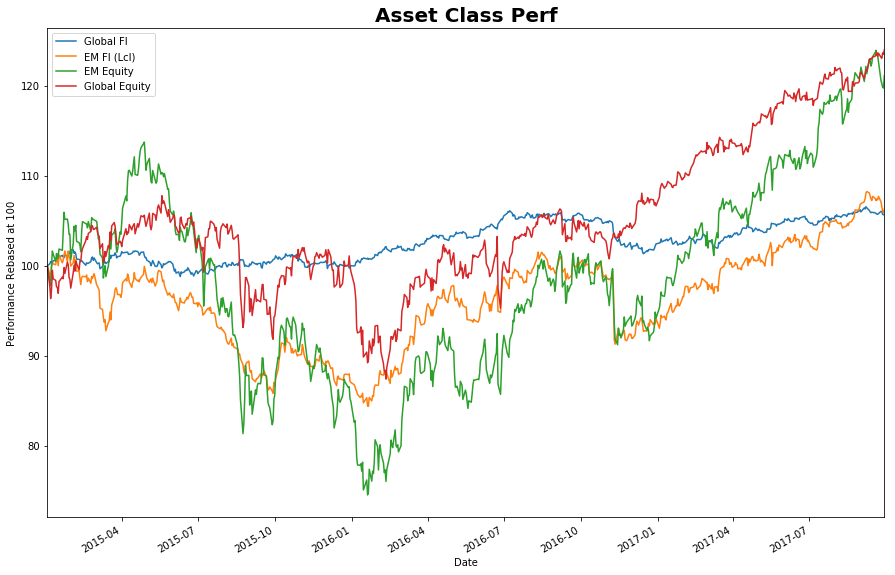

In [6]:
# Rename the tickers to something easier to read and visualise the price history
close_px.columns = ['Global FI', 'EM FI (Lcl)', 'EM Equity', 'Global Equity']
(close_px / close_px.iloc[0, :] * 100).plot(figsize=[15, 10])
plt.title('Asset Class Perf', fontsize=20, fontweight='bold')
plt.ylabel('Performance Rebased at 100')
plt.show()

In [7]:
# Generate daily log returns and initialise a set of random weights
returns = np.log(close_px / close_px.shift(1)).dropna()
wgts = np.random.random(len(returns.columns))
wgts /= np.sum(wgts)

In [8]:
def max_dd(returns):
    #assumes returns is a pandas Series
    
    #convert return series into price series based at 1
    r = returns.add(1).cumprod()
    
    #divide price series by the cumulative max
    dd = r.div(r.cummax()).sub(1)
    
    #min of dd returns the max drawdown
    mdd = dd.min()
    return mdd

In [9]:
def vol_contrib(wgts, returns):
    
    #calculate portfolio variance
    pvar = np.dot(wgts.T, np.dot(returns.cov() * 260, wgts))
    
    #calculate asset contribution to variance
    pvco = (np.dot(returns.cov() * 260, wgts) * wgts) / pvar
    
    return pvar, pvco

In [10]:
# Create function to define the possible target statistics
def statistics(wgts):
    #define risk-free
    rf = 0.01
    rets = pd.Series(np.dot(returns, wgts))
    
    #annalised daily log returns
    pret = np.sum(returns.mean() * wgts) * 260
    
    #portfolio var, vol, and sharpe
    pvar = vol_contrib(wgts, returns)[0]
    pvol = np.sqrt(pvar)
    pshp = (pret - rf) / pvol
    
    #portfolio drawdown as an absolute number
    pmdd = abs(max_dd(rets))
    
    #portfolio 5% cVaR as absolute number
    pcvr = abs(rets[rets < rets.quantile(0.05)].mean())
    
    #portfolio vol contribution and product of contrib
    pvco = vol_contrib(wgts, returns)[1]
    pvcp = pvco.prod()
    
    return np.array([pret, pvol, pshp, pmdd, pcvr, pvcp])

In [11]:
#set up the target variable to minimise
def min_func_variance(wgts):
    return statistics(wgts)[1] ** 2

In [12]:
def min_func_sharpe(wgts):
    return -statistics(wgts)[2]

In [13]:
def min_func_mdd(wgts):
    return statistics(wgts)[3]

In [14]:
def min_func_cVaR(wgts):
    return statistics(wgts)[4]

In [15]:
def min_func_equalRisk(wgts):
    return -statistics(wgts)[5]

In [16]:
#add basic constraints (e.g. weights must sum to 100%)
cons = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
)

In [17]:
#add weight bounds for each asset (no pos larger than 50% and none smaller than 5%)
bnds = tuple((0.05, 0.50) for x in range(len(returns.columns)))

In [18]:
%%time
'''
set up optimisation usin 'SLSQP' method (allows us to add constraints)
select the objective function from above to minimise
'''
opt_res = sco.minimize(min_func_equalRisk, wgts, method='SLSQP', bounds=bnds, constraints=cons)

Wall time: 285 ms


In [19]:
#check if the optimisation was successful or not
opt_res['success']

True

In [20]:
opt_wgts = pd.DataFrame(opt_res['x'], index=returns.columns, columns=['Weights'])
opt_wgts['Vol Contribution'] = pd.DataFrame(vol_contrib(opt_res['x'], returns)[1], index=returns.columns)
opt_wgts

,Weights,Vol Contribution
Global FI,0.500000,0.079140
EM FI (Lcl),0.266745,0.392874
EM Equity,0.087281,0.259194
Global Equity,0.145974,0.268792


In [21]:
#View statistics achieved
results = pd.DataFrame(statistics(opt_res['x'])[:5], index=['Exp Ret', 'Exp Vol', 'Sharpe Ratio', 'Max Drawdown', '1 Day cVaR'], columns=['Results'])
results

,Results
Exp Ret,0.034471
Exp Vol,0.057876
Sharpe Ratio,0.422813
Max Drawdown,0.103390
1 Day cVaR,0.008266


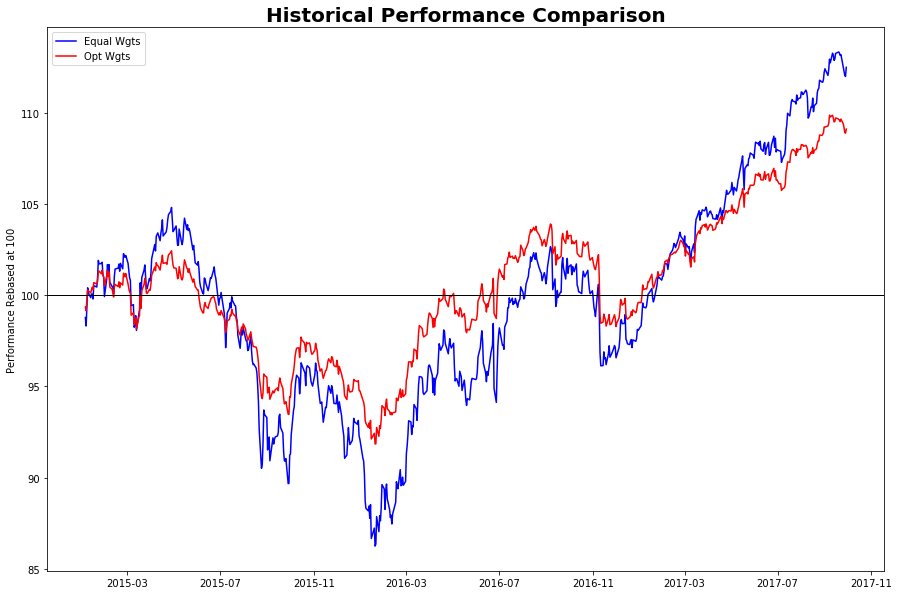

In [22]:
#inspect the historical time series (assumes rebalancing to current daily, very basic)
equal_wgts_ts = (returns.mean(axis=1).add(1)).cumprod() * 100
opt_wgts_ts = (pd.DataFrame(np.dot(returns, opt_wgts['Weights'])).add(1)).cumprod() * 100
x = returns.index

plt.figure(figsize=(15, 10))
plt.plot(x, equal_wgts_ts, label='Equal Wgts', c='b')
plt.plot(x, opt_wgts_ts, label='Opt Wgts', c='r')
plt.axhline(y=100, linewidth=1, color = 'black')
plt.title('Historical Performance Comparison', fontsize=20, fontweight='bold')
plt.ylabel('Performance Rebased at 100')
plt.legend(loc='best')
plt.show()